# Sentiment Analysis - Natural Language Processing

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
#import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
#import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Reading the Cleaned Dataset

In [2]:
# Read the file
df2 = pd.read_csv('C:/Users/guzel/Documents/amazon_beauty_products/cleaned_dataset.csv')

In [3]:
# Sample observations
df2.head(3)

,customer,product,review_text,rating_class,year,clean_text,tokens
0,A6VPK7X53QNAQ,B0000CC64W,If I had to choose only one product to take ca...,good,2009,choose one product take care face rest life wo...,"['choose', 'one', 'product', 'take', 'care', '..."
1,A3CHMHGSJSQ02J,B0000CC64W,Makes my skin lovely and smooth As a woman nea...,good,2013,make skin lovely smooth woman near need help g...,"['make', 'skin', 'lovely', 'smooth', 'woman', ..."
2,A1V1EP514B5H7Y,B0000CC64W,Works well at a reasonable price I've used thi...,good,2011,work well reasonable price use regenerating se...,"['work', 'well', 'reasonable', 'price', 'use',..."


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers. 

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

**Separating Response Variable and Feature**

In [4]:
df2['rating_class'] = df2['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [5]:
# Splitting the Data Set into Train and Test Sets
X = df2['clean_text']
y = df2['rating_class']

**Splitting Dataset into Train and Test Set**

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data. 

In [6]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(18381,)
Test Set Shape		:(6128,)


## 3. Selecting the Right Evaluation Metric

Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

**Confusion Matrix Plot Function**

Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.summer):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [9]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling 

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by females who bought beauty products in Amazon e-commerce online platform.  We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.  

Since the ratings of the reviews were not distributed normally, we decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 4-5 as 'Good' while dropping Rating 3 from the dataset. 

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition. 

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors. 

## 4.1 CountVectorizer Bag of Words

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

**"CountVectorizer"** implements both tokenization and occurrence counting in a single class. 

In [10]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [11]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 22158


In [12]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [13]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,___________________________________________________________i,_____________________________________________i,________________________________________product,_____________________addendum,aa,aaa,aaaaahhhhhhh,aaaah,aaaahhhh,aaack,...,zone,zoo,zoolander,zoom,zoomed,zoomlash,zwilling,zync,zz,zzzzap
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Creating a function for applying different algorithms**

In [14]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### Dummy Classifier

In [15]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.8456124626726497


**Classification Report**

In [16]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.08      0.08      0.08       514
           1       0.92      0.91      0.92      5614

    accuracy                           0.85      6128
   macro avg       0.50      0.50      0.50      6128
weighted avg       0.85      0.85      0.85      6128



**Confusion Matrix**

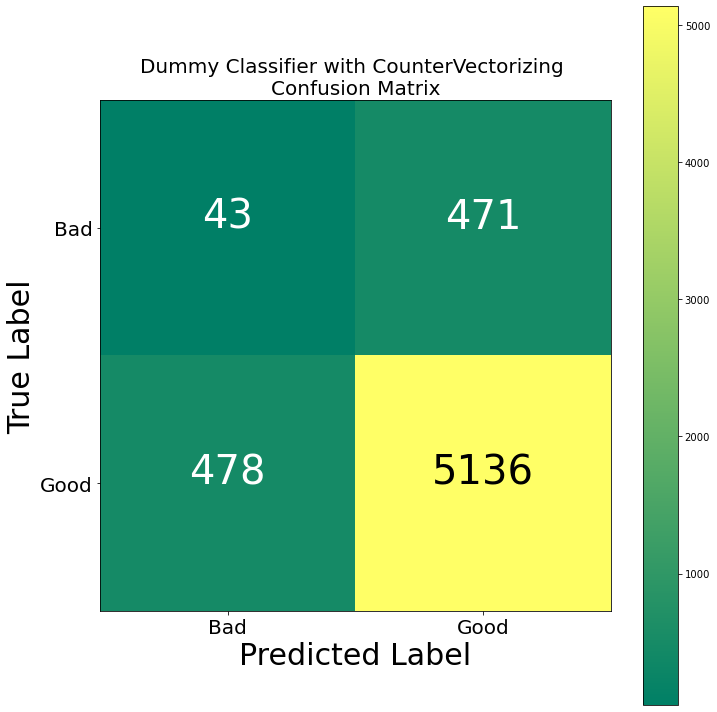

In [17]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred, "Dummy Classifier")

### 4.1.1 Logistic Regression with CountVectorizer

In [18]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9220280599789048


**Classification Report**

In [19]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.50      0.72      0.59       514
           1       0.97      0.93      0.95      5614

    accuracy                           0.91      6128
   macro avg       0.73      0.83      0.77      6128
weighted avg       0.93      0.91      0.92      6128



**Confusion Matrix**

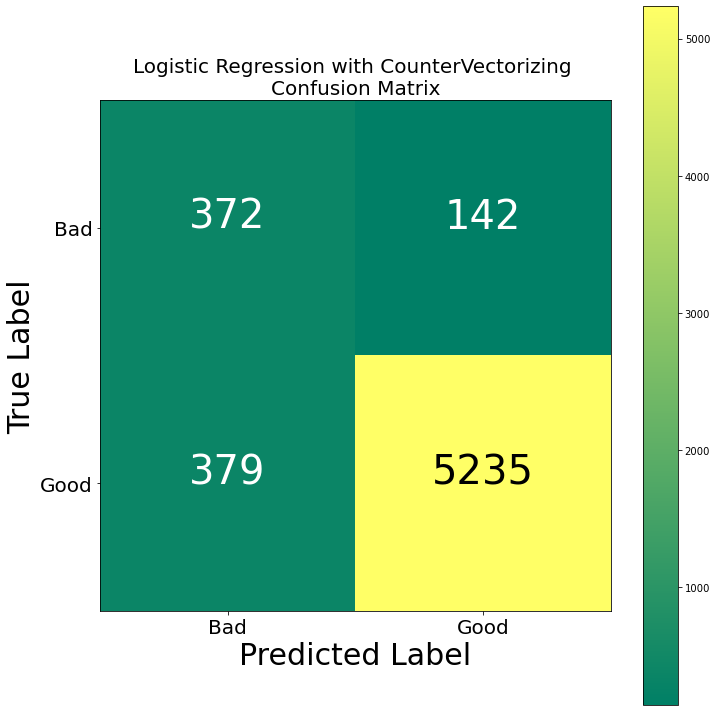

In [20]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer

In [21]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.8795786716588412


**Classification Report**

In [22]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.96      0.51      0.50      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

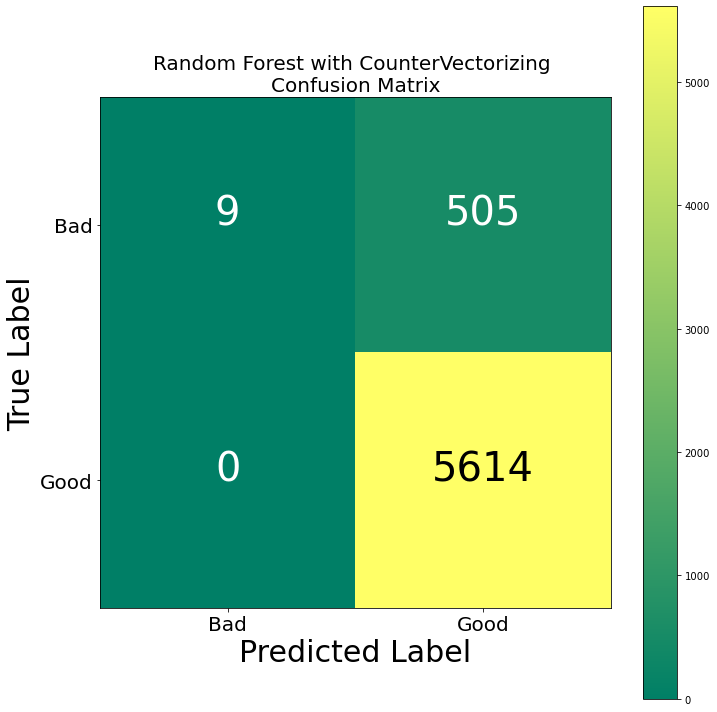

In [23]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer 

In [24]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9253976579632207


**Classification Report**

In [25]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.71      0.37      0.49       514
           1       0.95      0.99      0.97      5614

    accuracy                           0.93      6128
   macro avg       0.83      0.68      0.73      6128
weighted avg       0.93      0.93      0.93      6128



**Confusion Matrix**

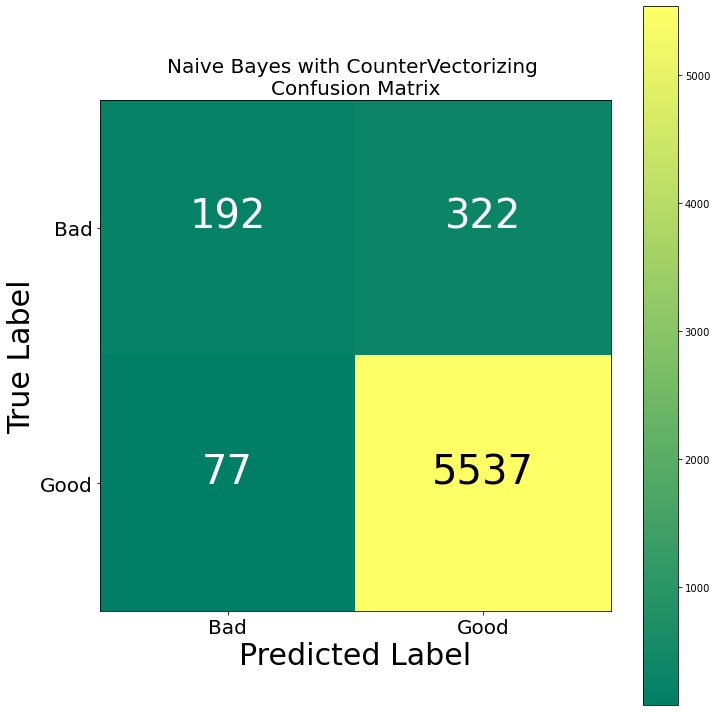

In [26]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [27]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8924275716372962


**Classification Report**

In [28]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.81      0.09      0.16       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.87      0.54      0.56      6128
weighted avg       0.91      0.92      0.89      6128



**Confusion Matrix**

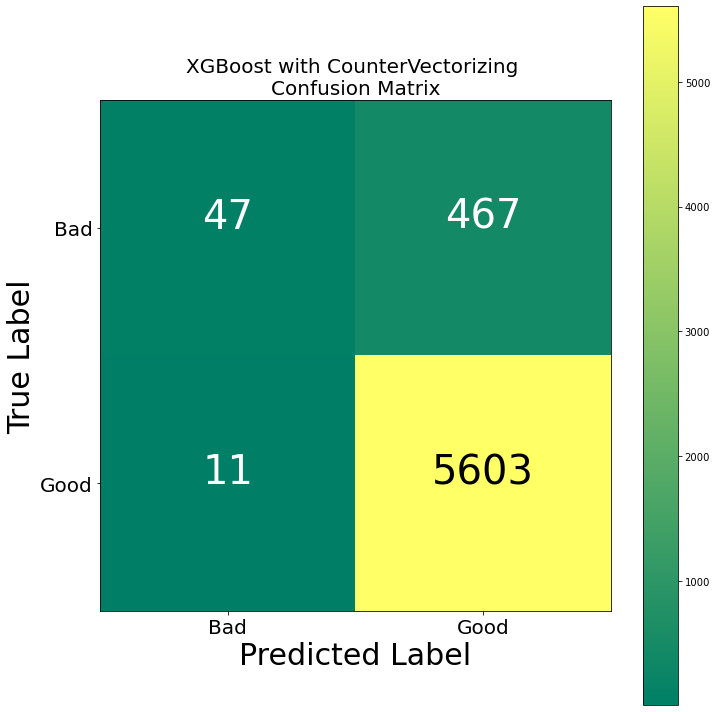

In [29]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoost with CountVectorizer

In [30]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1000, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.2965543	total: 109ms	remaining: 1m 48s
1:	learn: 0.2631413	total: 146ms	remaining: 1m 12s
2:	learn: 0.2537198	total: 187ms	remaining: 1m 2s
3:	learn: 0.2433207	total: 226ms	remaining: 56.2s
4:	learn: 0.2362618	total: 265ms	remaining: 52.7s
5:	learn: 0.2318158	total: 302ms	remaining: 50.1s
6:	learn: 0.2287170	total: 341ms	remaining: 48.3s
7:	learn: 0.2255151	total: 380ms	remaining: 47.2s
8:	learn: 0.2212223	total: 424ms	remaining: 46.7s
9:	learn: 0.2180974	total: 461ms	remaining: 45.6s
10:	learn: 0.2166248	total: 496ms	remaining: 44.6s
11:	learn: 0.2133017	total: 535ms	remaining: 44.1s
12:	learn: 0.2101386	total: 568ms	remaining: 43.1s
13:	learn: 0.2085146	total: 607ms	remaining: 42.7s
14:	learn: 0.2062349	total: 647ms	remaining: 42.5s
15:	learn: 0.2036595	total: 694ms	remaining: 42.7s
16:	learn: 0.2017880	total: 736ms	remaining: 42.6s
17:	learn: 0.1997544	total: 773ms	remaining: 42.2s
18:	learn: 0.1986094	total: 813ms	remaining: 42s
19:	learn: 0.1976753	total: 852ms	remaini

164:	learn: 0.1240719	total: 6.15s	remaining: 31.1s
165:	learn: 0.1239097	total: 6.18s	remaining: 31.1s
166:	learn: 0.1238013	total: 6.22s	remaining: 31s
167:	learn: 0.1236456	total: 6.26s	remaining: 31s
168:	learn: 0.1233203	total: 6.29s	remaining: 30.9s
169:	learn: 0.1231898	total: 6.33s	remaining: 30.9s
170:	learn: 0.1230614	total: 6.37s	remaining: 30.9s
171:	learn: 0.1229076	total: 6.41s	remaining: 30.8s
172:	learn: 0.1227701	total: 6.44s	remaining: 30.8s
173:	learn: 0.1226191	total: 6.48s	remaining: 30.8s
174:	learn: 0.1219748	total: 6.52s	remaining: 30.8s
175:	learn: 0.1218057	total: 6.56s	remaining: 30.7s
176:	learn: 0.1216590	total: 6.61s	remaining: 30.7s
177:	learn: 0.1215760	total: 6.65s	remaining: 30.7s
178:	learn: 0.1214329	total: 6.69s	remaining: 30.7s
179:	learn: 0.1213234	total: 6.73s	remaining: 30.6s
180:	learn: 0.1212201	total: 6.77s	remaining: 30.6s
181:	learn: 0.1210646	total: 6.81s	remaining: 30.6s
182:	learn: 0.1209355	total: 6.85s	remaining: 30.6s
183:	learn: 0.12

325:	learn: 0.0994396	total: 12.1s	remaining: 24.9s
326:	learn: 0.0993777	total: 12.1s	remaining: 24.9s
327:	learn: 0.0992980	total: 12.1s	remaining: 24.9s
328:	learn: 0.0992149	total: 12.2s	remaining: 24.8s
329:	learn: 0.0990661	total: 12.2s	remaining: 24.8s
330:	learn: 0.0989871	total: 12.2s	remaining: 24.7s
331:	learn: 0.0988392	total: 12.3s	remaining: 24.7s
332:	learn: 0.0985840	total: 12.3s	remaining: 24.7s
333:	learn: 0.0984265	total: 12.4s	remaining: 24.6s
334:	learn: 0.0981232	total: 12.4s	remaining: 24.6s
335:	learn: 0.0980417	total: 12.4s	remaining: 24.6s
336:	learn: 0.0979606	total: 12.5s	remaining: 24.5s
337:	learn: 0.0978708	total: 12.5s	remaining: 24.5s
338:	learn: 0.0977873	total: 12.5s	remaining: 24.5s
339:	learn: 0.0974943	total: 12.6s	remaining: 24.4s
340:	learn: 0.0974374	total: 12.6s	remaining: 24.4s
341:	learn: 0.0973569	total: 12.7s	remaining: 24.4s
342:	learn: 0.0970474	total: 12.7s	remaining: 24.3s
343:	learn: 0.0969657	total: 12.7s	remaining: 24.3s
344:	learn: 

484:	learn: 0.0836378	total: 18.2s	remaining: 19.3s
485:	learn: 0.0835878	total: 18.2s	remaining: 19.3s
486:	learn: 0.0835334	total: 18.3s	remaining: 19.2s
487:	learn: 0.0835159	total: 18.3s	remaining: 19.2s
488:	learn: 0.0834782	total: 18.3s	remaining: 19.2s
489:	learn: 0.0834270	total: 18.4s	remaining: 19.1s
490:	learn: 0.0833611	total: 18.4s	remaining: 19.1s
491:	learn: 0.0833106	total: 18.4s	remaining: 19s
492:	learn: 0.0832758	total: 18.5s	remaining: 19s
493:	learn: 0.0831061	total: 18.5s	remaining: 19s
494:	learn: 0.0829895	total: 18.5s	remaining: 18.9s
495:	learn: 0.0829534	total: 18.6s	remaining: 18.9s
496:	learn: 0.0829037	total: 18.6s	remaining: 18.8s
497:	learn: 0.0828734	total: 18.6s	remaining: 18.8s
498:	learn: 0.0828224	total: 18.7s	remaining: 18.8s
499:	learn: 0.0826397	total: 18.7s	remaining: 18.7s
500:	learn: 0.0823822	total: 18.8s	remaining: 18.7s
501:	learn: 0.0823176	total: 18.8s	remaining: 18.6s
502:	learn: 0.0822082	total: 18.8s	remaining: 18.6s
503:	learn: 0.0821

644:	learn: 0.0718168	total: 24.1s	remaining: 13.3s
645:	learn: 0.0718036	total: 24.2s	remaining: 13.2s
646:	learn: 0.0717661	total: 24.2s	remaining: 13.2s
647:	learn: 0.0717113	total: 24.3s	remaining: 13.2s
648:	learn: 0.0716867	total: 24.3s	remaining: 13.1s
649:	learn: 0.0713684	total: 24.3s	remaining: 13.1s
650:	learn: 0.0712661	total: 24.4s	remaining: 13.1s
651:	learn: 0.0712219	total: 24.4s	remaining: 13s
652:	learn: 0.0711897	total: 24.4s	remaining: 13s
653:	learn: 0.0711647	total: 24.5s	remaining: 12.9s
654:	learn: 0.0710977	total: 24.5s	remaining: 12.9s
655:	learn: 0.0710609	total: 24.5s	remaining: 12.9s
656:	learn: 0.0710234	total: 24.6s	remaining: 12.8s
657:	learn: 0.0709968	total: 24.6s	remaining: 12.8s
658:	learn: 0.0709324	total: 24.6s	remaining: 12.7s
659:	learn: 0.0707786	total: 24.7s	remaining: 12.7s
660:	learn: 0.0707339	total: 24.7s	remaining: 12.7s
661:	learn: 0.0706931	total: 24.7s	remaining: 12.6s
662:	learn: 0.0706586	total: 24.8s	remaining: 12.6s
663:	learn: 0.07

804:	learn: 0.0633547	total: 30.6s	remaining: 7.4s
805:	learn: 0.0633278	total: 30.6s	remaining: 7.37s
806:	learn: 0.0633017	total: 30.7s	remaining: 7.33s
807:	learn: 0.0632746	total: 30.7s	remaining: 7.3s
808:	learn: 0.0632498	total: 30.8s	remaining: 7.26s
809:	learn: 0.0632074	total: 30.8s	remaining: 7.22s
810:	learn: 0.0631861	total: 30.8s	remaining: 7.19s
811:	learn: 0.0631605	total: 30.9s	remaining: 7.15s
812:	learn: 0.0629633	total: 30.9s	remaining: 7.11s
813:	learn: 0.0629434	total: 31s	remaining: 7.08s
814:	learn: 0.0629123	total: 31s	remaining: 7.04s
815:	learn: 0.0628959	total: 31s	remaining: 7s
816:	learn: 0.0628540	total: 31.1s	remaining: 6.96s
817:	learn: 0.0627574	total: 31.1s	remaining: 6.92s
818:	learn: 0.0627570	total: 31.1s	remaining: 6.88s
819:	learn: 0.0627205	total: 31.2s	remaining: 6.85s
820:	learn: 0.0627167	total: 31.2s	remaining: 6.81s
821:	learn: 0.0626792	total: 31.3s	remaining: 6.77s
822:	learn: 0.0625631	total: 31.3s	remaining: 6.74s
823:	learn: 0.0623644	t

963:	learn: 0.0557367	total: 36.8s	remaining: 1.37s
964:	learn: 0.0557134	total: 36.8s	remaining: 1.33s
965:	learn: 0.0556832	total: 36.9s	remaining: 1.3s
966:	learn: 0.0556556	total: 36.9s	remaining: 1.26s
967:	learn: 0.0555741	total: 37s	remaining: 1.22s
968:	learn: 0.0555486	total: 37s	remaining: 1.18s
969:	learn: 0.0555025	total: 37s	remaining: 1.15s
970:	learn: 0.0554807	total: 37.1s	remaining: 1.11s
971:	learn: 0.0554723	total: 37.1s	remaining: 1.07s
972:	learn: 0.0554508	total: 37.1s	remaining: 1.03s
973:	learn: 0.0554403	total: 37.2s	remaining: 993ms
974:	learn: 0.0553840	total: 37.2s	remaining: 954ms
975:	learn: 0.0553549	total: 37.3s	remaining: 916ms
976:	learn: 0.0552346	total: 37.3s	remaining: 878ms
977:	learn: 0.0550814	total: 37.3s	remaining: 840ms
978:	learn: 0.0550064	total: 37.4s	remaining: 802ms
979:	learn: 0.0549935	total: 37.4s	remaining: 763ms
980:	learn: 0.0549736	total: 37.4s	remaining: 725ms
981:	learn: 0.0549357	total: 37.5s	remaining: 687ms
982:	learn: 0.05477

**Classification Report**

In [31]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.70      0.43      0.53       514
           1       0.95      0.98      0.97      5614

    accuracy                           0.94      6128
   macro avg       0.83      0.70      0.75      6128
weighted avg       0.93      0.94      0.93      6128



**Confusion Matrix**

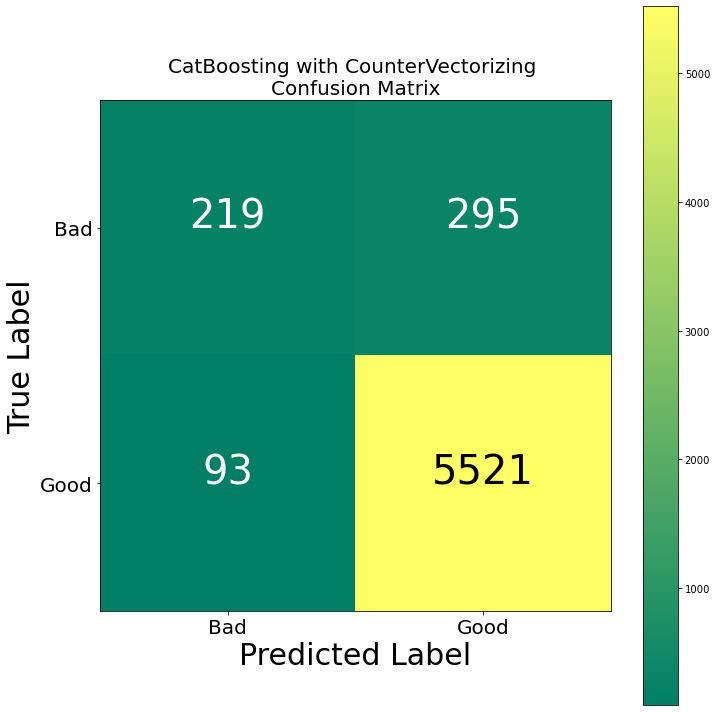

In [32]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of Models with CountVectorizer

**Functions for Algorithms Comparison**

In [33]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [34]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

**Function for f1 Score Plotting**

In [35]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

**Algorithms Comparison with CountVectorizer**

In [36]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [37]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.914980 bad       0.495340  0.723735  0.588142   
                                  good      0.973591  0.932490  0.952598   
                                  average   0.933477  0.914980  0.922028   
           Random Forest 0.917591 bad       1.000000  0.017510  0.034417   
                                  good      0.917470  1.000000  0.956959   
                                  average   0.924393  0.917591  0.879579   
           Naive Bayes   0.934889 bad       0.713755  0.373541  0.490421   
                                  good      0.945042  0.986284  0.965223   
                                  average   0.925642  0.934889  0.925398   
           XGBoost       0.921997 bad       0.810345  0.091440  0.164336   
                                  good      0.923064  0.998041  0.959089   
                                  average   0.913610  0.921997  0.892428   
           CatBoost      0.936684 bad       0.701923  0.426070  0.530266   
                                  good      0.949278  0.983434  0.966054   
                                  average   0.928530  0.936684  0.929502   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.914980 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917591 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.934889 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.921997 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.936684 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 Score - Models with CountVectorizer**

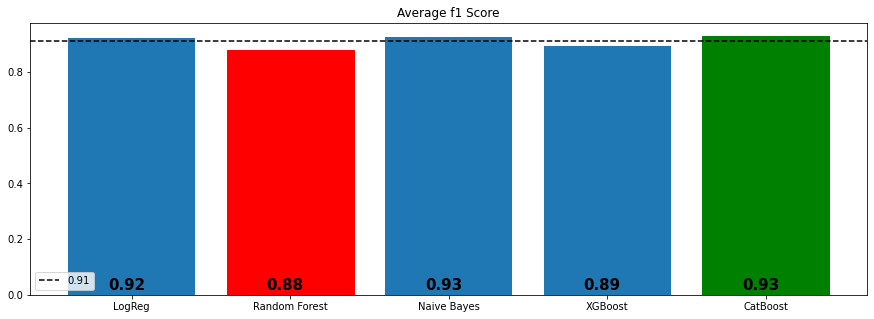

In [38]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

## 4.2 TF-IDF 

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [39]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [40]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8954521474029395


**Classification Report**

In [41]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.39      0.84      0.53       514
           1       0.98      0.88      0.93      5614

    accuracy                           0.88      6128
   macro avg       0.69      0.86      0.73      6128
weighted avg       0.93      0.88      0.90      6128



**Confusion Matrix**

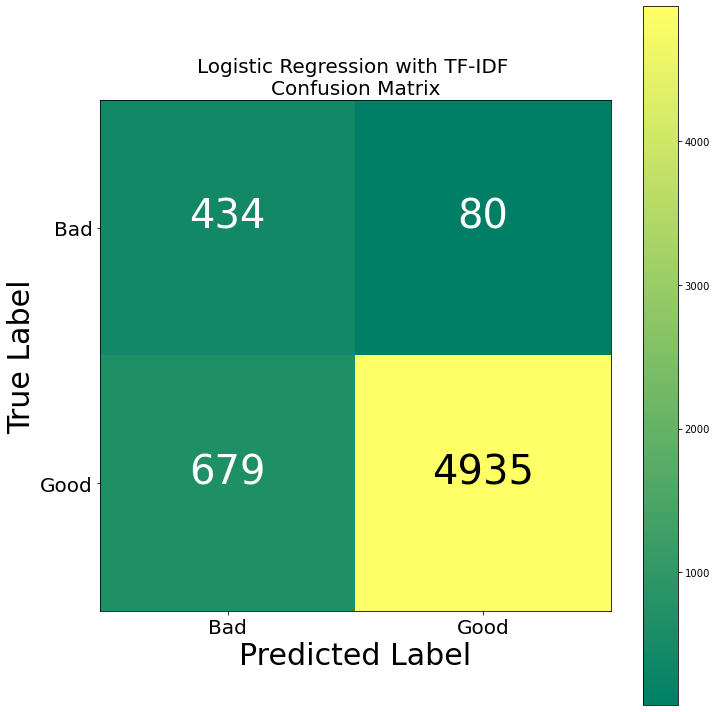

In [42]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [43]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8784034081520026


**Classification Report**

In [44]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

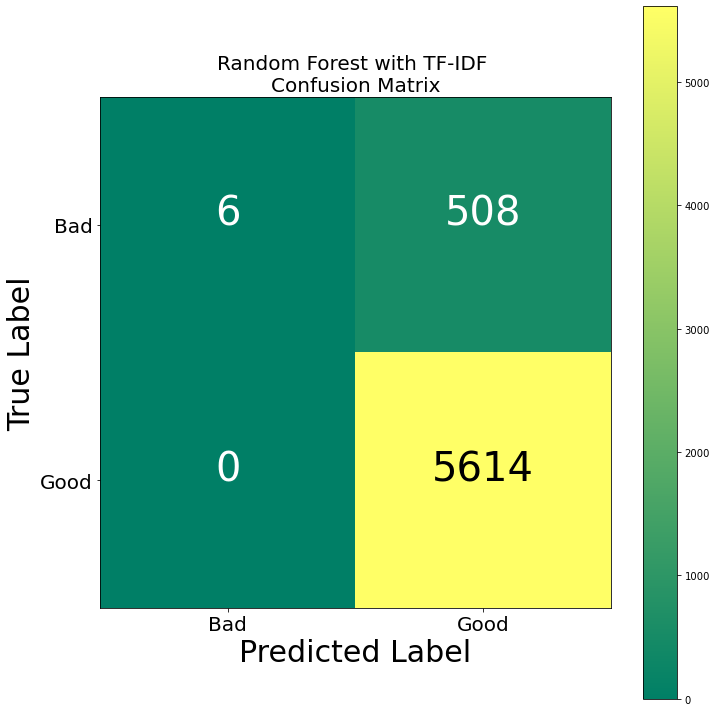

In [45]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [46]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.8760199155649777


**Classification Report**

In [47]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.46      0.50      0.48      6128
weighted avg       0.84      0.92      0.88      6128



**Confusion Matrix**

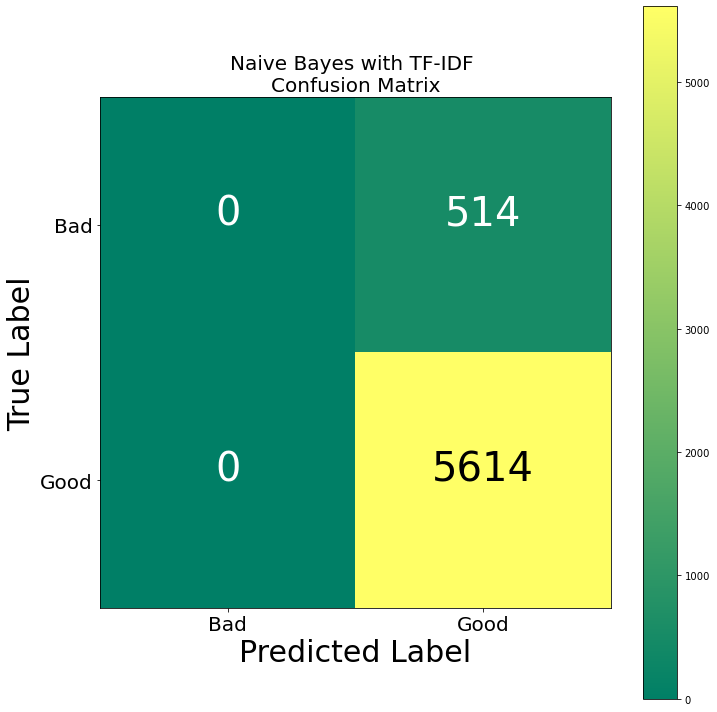

In [48]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [49]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.898017671744955


**Classification Report**

In [50]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.79      0.13      0.22       514
           1       0.93      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.86      0.56      0.59      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

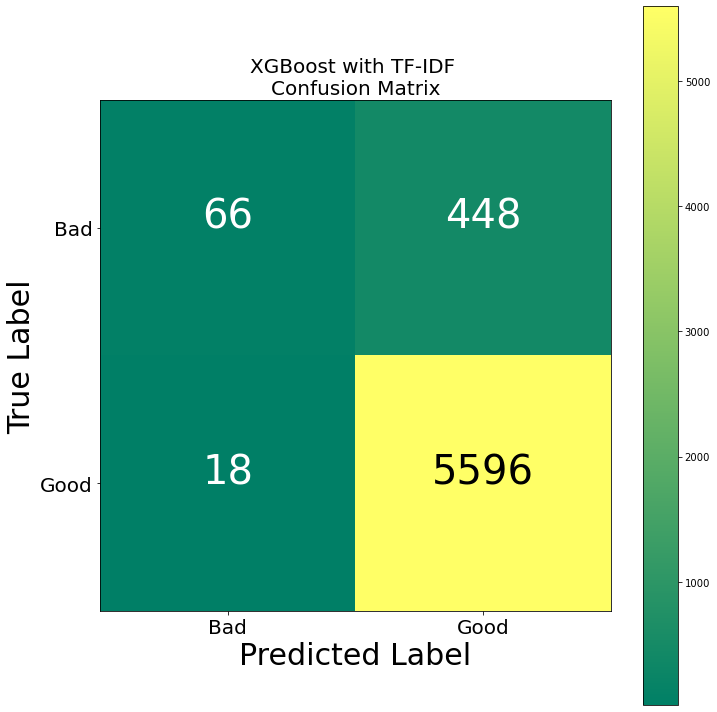

In [51]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboost with TF-IDF

In [52]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.3013803	total: 57.7ms	remaining: 1m 26s
1:	learn: 0.2713315	total: 105ms	remaining: 1m 18s
2:	learn: 0.2590734	total: 151ms	remaining: 1m 15s
3:	learn: 0.2531605	total: 198ms	remaining: 1m 14s
4:	learn: 0.2462058	total: 245ms	remaining: 1m 13s
5:	learn: 0.2414980	total: 293ms	remaining: 1m 12s
6:	learn: 0.2339505	total: 341ms	remaining: 1m 12s
7:	learn: 0.2306544	total: 386ms	remaining: 1m 12s
8:	learn: 0.2278351	total: 431ms	remaining: 1m 11s
9:	learn: 0.2223690	total: 481ms	remaining: 1m 11s
10:	learn: 0.2203807	total: 526ms	remaining: 1m 11s
11:	learn: 0.2139573	total: 574ms	remaining: 1m 11s
12:	learn: 0.2101523	total: 621ms	remaining: 1m 10s
13:	learn: 0.2077649	total: 667ms	remaining: 1m 10s
14:	learn: 0.2054099	total: 710ms	remaining: 1m 10s
15:	learn: 0.2035748	total: 757ms	remaining: 1m 10s
16:	learn: 0.2023760	total: 802ms	remaining: 1m 9s
17:	learn: 0.1999541	total: 848ms	remaining: 1m 9s
18:	learn: 0.1984444	total: 893ms	remaining: 1m 9s
19:	learn: 0.1971364	tot

165:	learn: 0.1094346	total: 7.39s	remaining: 59.4s
166:	learn: 0.1092743	total: 7.43s	remaining: 59.3s
167:	learn: 0.1090547	total: 7.48s	remaining: 59.3s
168:	learn: 0.1087773	total: 7.52s	remaining: 59.2s
169:	learn: 0.1085913	total: 7.56s	remaining: 59.2s
170:	learn: 0.1083285	total: 7.61s	remaining: 59.1s
171:	learn: 0.1081285	total: 7.65s	remaining: 59.1s
172:	learn: 0.1079251	total: 7.7s	remaining: 59s
173:	learn: 0.1077554	total: 7.74s	remaining: 59s
174:	learn: 0.1075606	total: 7.78s	remaining: 58.9s
175:	learn: 0.1073748	total: 7.83s	remaining: 58.9s
176:	learn: 0.1071846	total: 7.87s	remaining: 58.8s
177:	learn: 0.1069841	total: 7.91s	remaining: 58.8s
178:	learn: 0.1067337	total: 7.96s	remaining: 58.8s
179:	learn: 0.1065122	total: 8s	remaining: 58.7s
180:	learn: 0.1060924	total: 8.05s	remaining: 58.7s
181:	learn: 0.1058551	total: 8.09s	remaining: 58.6s
182:	learn: 0.1056309	total: 8.14s	remaining: 58.6s
183:	learn: 0.1052455	total: 8.18s	remaining: 58.5s
184:	learn: 0.105008

325:	learn: 0.0802352	total: 14.4s	remaining: 51.9s
326:	learn: 0.0801085	total: 14.4s	remaining: 51.8s
327:	learn: 0.0800087	total: 14.5s	remaining: 51.8s
328:	learn: 0.0798959	total: 14.5s	remaining: 51.7s
329:	learn: 0.0798070	total: 14.6s	remaining: 51.7s
330:	learn: 0.0796944	total: 14.6s	remaining: 51.6s
331:	learn: 0.0795807	total: 14.7s	remaining: 51.6s
332:	learn: 0.0794706	total: 14.7s	remaining: 51.5s
333:	learn: 0.0793595	total: 14.7s	remaining: 51.5s
334:	learn: 0.0792570	total: 14.8s	remaining: 51.4s
335:	learn: 0.0791405	total: 14.8s	remaining: 51.4s
336:	learn: 0.0790308	total: 14.9s	remaining: 51.3s
337:	learn: 0.0789386	total: 14.9s	remaining: 51.3s
338:	learn: 0.0788640	total: 15s	remaining: 51.3s
339:	learn: 0.0787672	total: 15s	remaining: 51.3s
340:	learn: 0.0783437	total: 15.1s	remaining: 51.3s
341:	learn: 0.0782157	total: 15.1s	remaining: 51.2s
342:	learn: 0.0777664	total: 15.2s	remaining: 51.2s
343:	learn: 0.0774470	total: 15.2s	remaining: 51.2s
344:	learn: 0.07

484:	learn: 0.0622519	total: 21.3s	remaining: 44.6s
485:	learn: 0.0621844	total: 21.4s	remaining: 44.6s
486:	learn: 0.0621173	total: 21.4s	remaining: 44.5s
487:	learn: 0.0620322	total: 21.5s	remaining: 44.5s
488:	learn: 0.0618290	total: 21.5s	remaining: 44.5s
489:	learn: 0.0616051	total: 21.5s	remaining: 44.4s
490:	learn: 0.0615577	total: 21.6s	remaining: 44.4s
491:	learn: 0.0614997	total: 21.6s	remaining: 44.3s
492:	learn: 0.0614432	total: 21.7s	remaining: 44.3s
493:	learn: 0.0613783	total: 21.7s	remaining: 44.2s
494:	learn: 0.0612800	total: 21.8s	remaining: 44.2s
495:	learn: 0.0612135	total: 21.8s	remaining: 44.1s
496:	learn: 0.0611484	total: 21.8s	remaining: 44.1s
497:	learn: 0.0610828	total: 21.9s	remaining: 44s
498:	learn: 0.0609853	total: 21.9s	remaining: 44s
499:	learn: 0.0609185	total: 22s	remaining: 43.9s
500:	learn: 0.0607690	total: 22s	remaining: 43.9s
501:	learn: 0.0607043	total: 22.1s	remaining: 43.8s
502:	learn: 0.0606437	total: 22.1s	remaining: 43.8s
503:	learn: 0.060575

647:	learn: 0.0503363	total: 28.3s	remaining: 37.2s
648:	learn: 0.0502964	total: 28.4s	remaining: 37.2s
649:	learn: 0.0502412	total: 28.4s	remaining: 37.1s
650:	learn: 0.0501743	total: 28.4s	remaining: 37.1s
651:	learn: 0.0501289	total: 28.5s	remaining: 37.1s
652:	learn: 0.0500624	total: 28.5s	remaining: 37s
653:	learn: 0.0500252	total: 28.6s	remaining: 37s
654:	learn: 0.0499779	total: 28.6s	remaining: 36.9s
655:	learn: 0.0498370	total: 28.7s	remaining: 36.9s
656:	learn: 0.0497948	total: 28.7s	remaining: 36.8s
657:	learn: 0.0497535	total: 28.7s	remaining: 36.8s
658:	learn: 0.0497222	total: 28.8s	remaining: 36.7s
659:	learn: 0.0496778	total: 28.8s	remaining: 36.7s
660:	learn: 0.0495925	total: 28.9s	remaining: 36.6s
661:	learn: 0.0494553	total: 28.9s	remaining: 36.6s
662:	learn: 0.0494319	total: 29s	remaining: 36.6s
663:	learn: 0.0493871	total: 29s	remaining: 36.5s
664:	learn: 0.0493426	total: 29s	remaining: 36.5s
665:	learn: 0.0492988	total: 29.1s	remaining: 36.4s
666:	learn: 0.0492448	

810:	learn: 0.0409582	total: 35.3s	remaining: 30s
811:	learn: 0.0409246	total: 35.4s	remaining: 30s
812:	learn: 0.0409032	total: 35.4s	remaining: 29.9s
813:	learn: 0.0408751	total: 35.5s	remaining: 29.9s
814:	learn: 0.0408464	total: 35.5s	remaining: 29.8s
815:	learn: 0.0408261	total: 35.5s	remaining: 29.8s
816:	learn: 0.0407948	total: 35.6s	remaining: 29.8s
817:	learn: 0.0407632	total: 35.6s	remaining: 29.7s
818:	learn: 0.0407410	total: 35.7s	remaining: 29.7s
819:	learn: 0.0407093	total: 35.7s	remaining: 29.6s
820:	learn: 0.0406961	total: 35.8s	remaining: 29.6s
821:	learn: 0.0406673	total: 35.8s	remaining: 29.5s
822:	learn: 0.0406264	total: 35.8s	remaining: 29.5s
823:	learn: 0.0405971	total: 35.9s	remaining: 29.4s
824:	learn: 0.0405660	total: 35.9s	remaining: 29.4s
825:	learn: 0.0405388	total: 36s	remaining: 29.4s
826:	learn: 0.0405082	total: 36s	remaining: 29.3s
827:	learn: 0.0404850	total: 36.1s	remaining: 29.3s
828:	learn: 0.0404543	total: 36.1s	remaining: 29.2s
829:	learn: 0.040419

970:	learn: 0.0353927	total: 42.3s	remaining: 23.1s
971:	learn: 0.0353678	total: 42.4s	remaining: 23s
972:	learn: 0.0351875	total: 42.4s	remaining: 23s
973:	learn: 0.0351572	total: 42.5s	remaining: 22.9s
974:	learn: 0.0351337	total: 42.5s	remaining: 22.9s
975:	learn: 0.0350327	total: 42.5s	remaining: 22.8s
976:	learn: 0.0350326	total: 42.6s	remaining: 22.8s
977:	learn: 0.0349836	total: 42.6s	remaining: 22.8s
978:	learn: 0.0349078	total: 42.7s	remaining: 22.7s
979:	learn: 0.0348584	total: 42.7s	remaining: 22.7s
980:	learn: 0.0348081	total: 42.7s	remaining: 22.6s
981:	learn: 0.0348065	total: 42.8s	remaining: 22.6s
982:	learn: 0.0347821	total: 42.8s	remaining: 22.5s
983:	learn: 0.0347570	total: 42.9s	remaining: 22.5s
984:	learn: 0.0347553	total: 42.9s	remaining: 22.4s
985:	learn: 0.0347312	total: 43s	remaining: 22.4s
986:	learn: 0.0347309	total: 43s	remaining: 22.3s
987:	learn: 0.0347078	total: 43s	remaining: 22.3s
988:	learn: 0.0346945	total: 43.1s	remaining: 22.3s
989:	learn: 0.0346658	

1129:	learn: 0.0305781	total: 49.1s	remaining: 16.1s
1130:	learn: 0.0305656	total: 49.1s	remaining: 16s
1131:	learn: 0.0305444	total: 49.2s	remaining: 16s
1132:	learn: 0.0305247	total: 49.2s	remaining: 15.9s
1133:	learn: 0.0305045	total: 49.3s	remaining: 15.9s
1134:	learn: 0.0305028	total: 49.3s	remaining: 15.9s
1135:	learn: 0.0304812	total: 49.3s	remaining: 15.8s
1136:	learn: 0.0304502	total: 49.4s	remaining: 15.8s
1137:	learn: 0.0304463	total: 49.4s	remaining: 15.7s
1138:	learn: 0.0304284	total: 49.5s	remaining: 15.7s
1139:	learn: 0.0303873	total: 49.5s	remaining: 15.6s
1140:	learn: 0.0303708	total: 49.5s	remaining: 15.6s
1141:	learn: 0.0303276	total: 49.6s	remaining: 15.5s
1142:	learn: 0.0302998	total: 49.6s	remaining: 15.5s
1143:	learn: 0.0302434	total: 49.7s	remaining: 15.5s
1144:	learn: 0.0302417	total: 49.7s	remaining: 15.4s
1145:	learn: 0.0302164	total: 49.7s	remaining: 15.4s
1146:	learn: 0.0301926	total: 49.8s	remaining: 15.3s
1147:	learn: 0.0301507	total: 49.8s	remaining: 15.

1288:	learn: 0.0271727	total: 55.7s	remaining: 9.11s
1289:	learn: 0.0271565	total: 55.7s	remaining: 9.07s
1290:	learn: 0.0271447	total: 55.8s	remaining: 9.03s
1291:	learn: 0.0271163	total: 55.8s	remaining: 8.98s
1292:	learn: 0.0271072	total: 55.9s	remaining: 8.94s
1293:	learn: 0.0270970	total: 55.9s	remaining: 8.9s
1294:	learn: 0.0270936	total: 55.9s	remaining: 8.85s
1295:	learn: 0.0270774	total: 56s	remaining: 8.81s
1296:	learn: 0.0270762	total: 56s	remaining: 8.77s
1297:	learn: 0.0270609	total: 56.1s	remaining: 8.72s
1298:	learn: 0.0270528	total: 56.1s	remaining: 8.68s
1299:	learn: 0.0270366	total: 56.1s	remaining: 8.64s
1300:	learn: 0.0270364	total: 56.2s	remaining: 8.59s
1301:	learn: 0.0270213	total: 56.2s	remaining: 8.55s
1302:	learn: 0.0270063	total: 56.3s	remaining: 8.51s
1303:	learn: 0.0269797	total: 56.3s	remaining: 8.46s
1304:	learn: 0.0269556	total: 56.4s	remaining: 8.42s
1305:	learn: 0.0269372	total: 56.4s	remaining: 8.38s
1306:	learn: 0.0269218	total: 56.4s	remaining: 8.33

1449:	learn: 0.0249224	total: 1m 2s	remaining: 2.15s
1450:	learn: 0.0249082	total: 1m 2s	remaining: 2.11s
1451:	learn: 0.0249072	total: 1m 2s	remaining: 2.06s
1452:	learn: 0.0248958	total: 1m 2s	remaining: 2.02s
1453:	learn: 0.0248750	total: 1m 2s	remaining: 1.98s
1454:	learn: 0.0248617	total: 1m 2s	remaining: 1.94s
1455:	learn: 0.0248603	total: 1m 2s	remaining: 1.89s
1456:	learn: 0.0248563	total: 1m 2s	remaining: 1.85s
1457:	learn: 0.0248466	total: 1m 2s	remaining: 1.81s
1458:	learn: 0.0248426	total: 1m 2s	remaining: 1.76s
1459:	learn: 0.0248350	total: 1m 2s	remaining: 1.72s
1460:	learn: 0.0247578	total: 1m 2s	remaining: 1.68s
1461:	learn: 0.0247561	total: 1m 2s	remaining: 1.64s
1462:	learn: 0.0247371	total: 1m 2s	remaining: 1.59s
1463:	learn: 0.0247360	total: 1m 3s	remaining: 1.55s
1464:	learn: 0.0247249	total: 1m 3s	remaining: 1.51s
1465:	learn: 0.0247158	total: 1m 3s	remaining: 1.46s
1466:	learn: 0.0247062	total: 1m 3s	remaining: 1.42s
1467:	learn: 0.0247051	total: 1m 3s	remaining:

**Classification Report**

In [53]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.68      0.40      0.50       514
           1       0.95      0.98      0.96      5614

    accuracy                           0.93      6128
   macro avg       0.81      0.69      0.73      6128
weighted avg       0.92      0.93      0.93      6128



**Confusion Matrix**

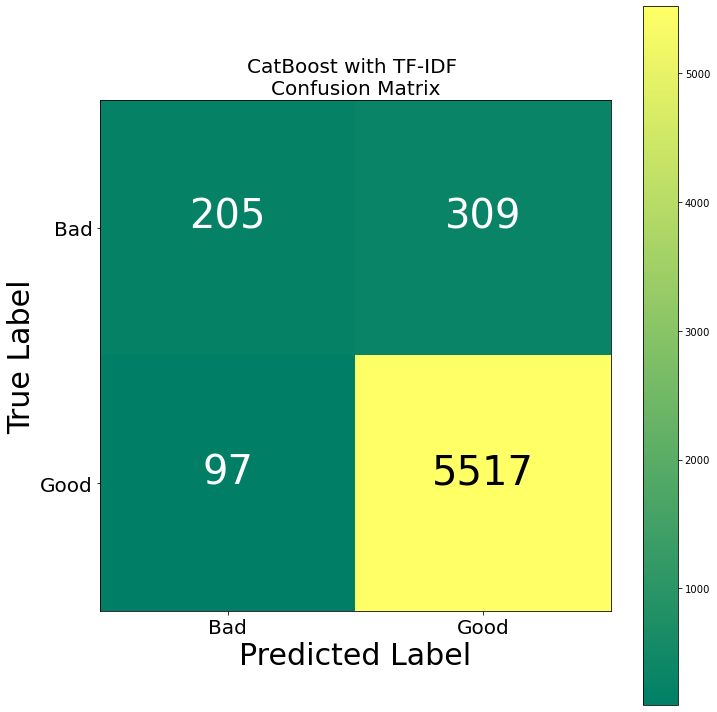

In [54]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

### 4.2.6 Comparision of Models with TF-IDF Vectorizer

In [55]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table - TF-IDF Vectorizing**

In [56]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.876142 bad       0.389937  0.844358  0.533497   
                                  good      0.984048  0.879052  0.928592   
                                  average   0.934215  0.876142  0.895452   
           Random Forest 0.917102 bad       1.000000  0.011673  0.023077   
                                  good      0.917021  1.000000  0.956714   
                                  average   0.923981  0.917102  0.878403   
           Naive Bayes   0.916123 bad       0.000000  0.000000  0.000000   
                                  good      0.916123  1.000000  0.956226   
                                  average   0.839281  0.916123  0.876020   
           XGBoost       0.923956 bad       0.785714  0.128405  0.220736   
                                  good      0.925877  0.996794  0.960027   
                                  average   0.914120  0.923956  0.898018   
           CatBoost      0.933747 bad       0.678808  0.398833  0.502451   
                                  good      0.946962  0.982722  0.964510   
                                  average   0.924470  0.933747  0.925754   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.876142 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917102 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.916123 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.923956 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.933747 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Models with TF-IDF Vectorizer**

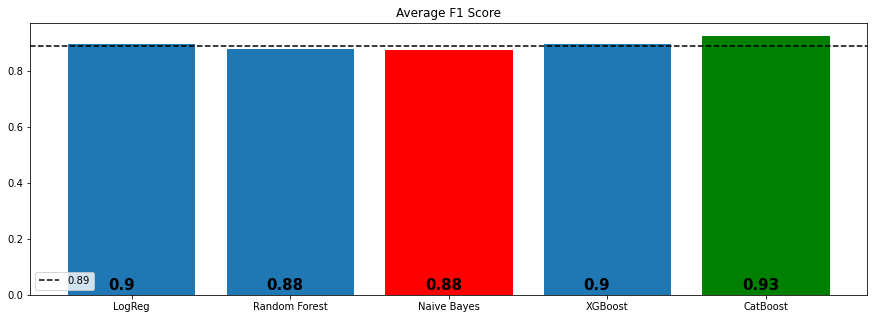

In [57]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4.3 Hashing Vectorizer

Hash Vectorizer is designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes. The downside of this method is that once vectorized, the features’ names can no longer be retrieved.

In [60]:
# Create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1))
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

### 4.3.1 Logistic Regression with Hash Vectorizer

In [61]:
# Call the modeling function for logistic regression with Hash Vectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_logreg = y_pred

f1 score: 0.8642454791536459


**Classification Report**

In [62]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_logreg))

              precision    recall  f1-score   support

           0       0.31      0.82      0.45       514
           1       0.98      0.83      0.90      5614

    accuracy                           0.83      6128
   macro avg       0.65      0.83      0.68      6128
weighted avg       0.93      0.83      0.86      6128



**Confusion Matrix**

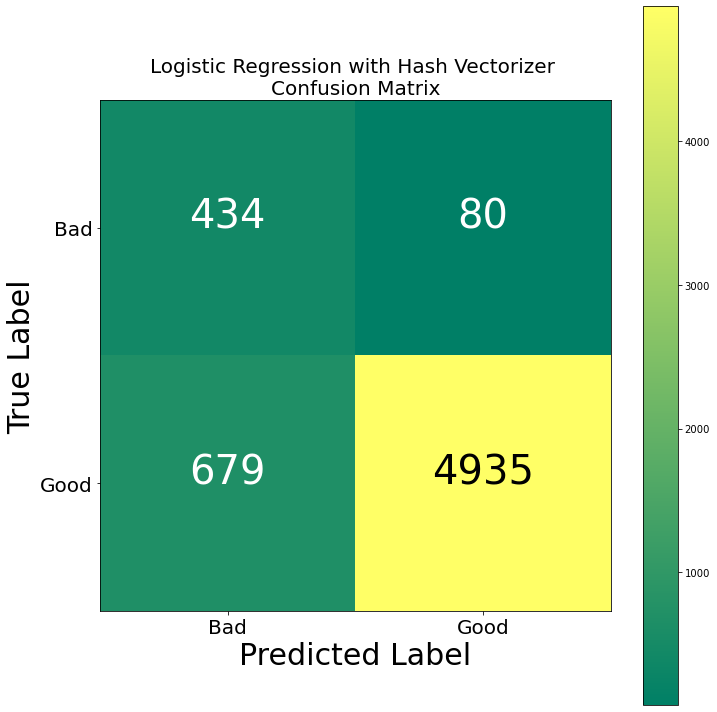

In [63]:
# Print confusion matrix for logistic regression with Hash Vectorizer
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "Hash Vectorizer")

### 4.3.2 Random Forest with Hash Vectorizer

In [64]:
# Call the modeling function for random forest classifier with Hash Vectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_rf = y_pred

f1 score: 0.879188119188214


**Classification Report**

In [65]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_rf))

              precision    recall  f1-score   support

           0       1.00      0.02      0.03       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.96      0.51      0.49      6128
weighted avg       0.92      0.92      0.88      6128



**Confusion Matrix**

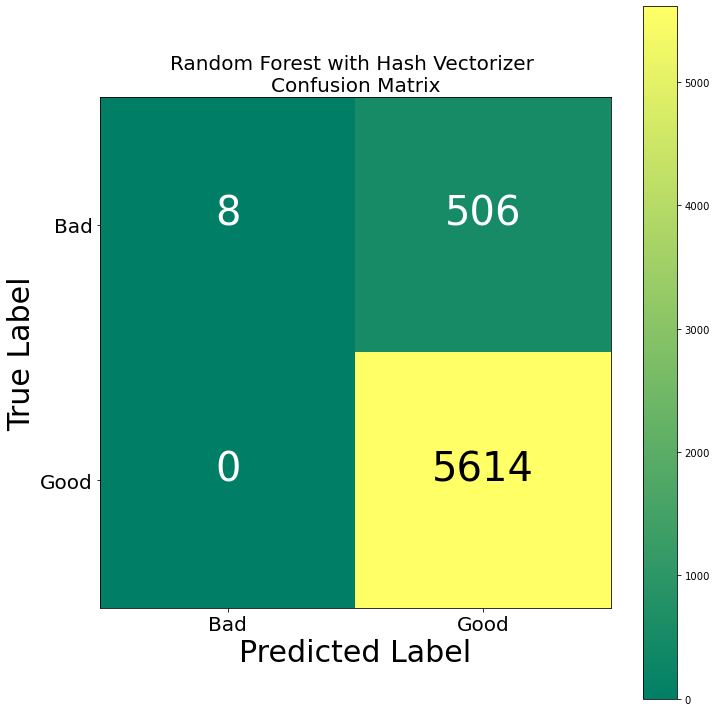

In [66]:
# Print confusion matrix for random forest classifier with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_rf, "Random Forest", "Hash Vectorizer")

### 4.3.3 Naive Bayes with Hash Vectorizer

In [78]:
# To eliminate ValueError: Negative values in data passed to MultinomialNB (input X), add to Hash Vectorizer "non_negative=True" or "alternate_sign=False" like current case according to the versions' argument
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1), alternate_sign=False)
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

In [79]:
# Call the modeling function for naive bayes with Hash Vectorizer and print f1 score
modeling(MultinomialNB(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_nb = y_pred

f1 score: 0.8757755441069546


**Classification Report**

In [80]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.46      0.50      0.48      6128
weighted avg       0.84      0.92      0.88      6128



**Confusion Matrix**

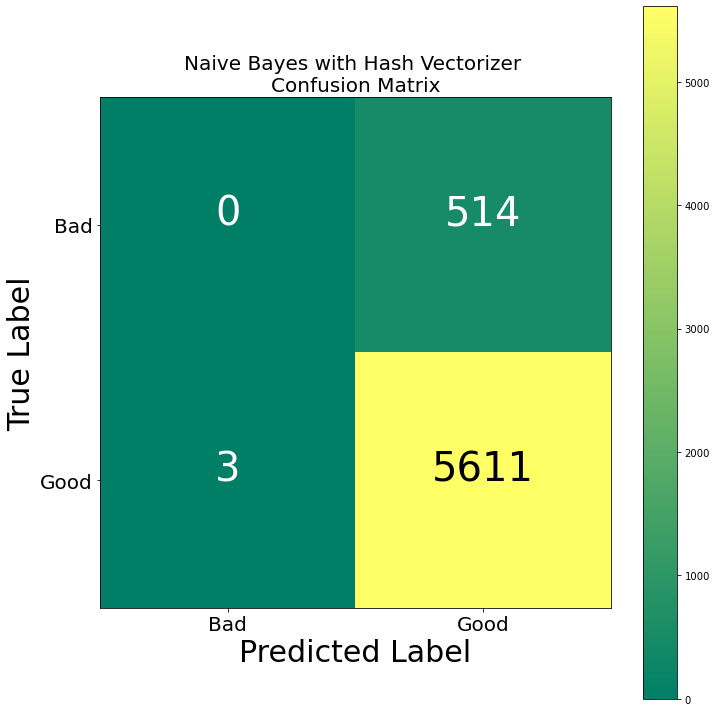

In [81]:
# Print confusion matrix for naive bayes with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_nb, "Naive Bayes", "Hash Vectorizer")

### 4.3.4 XGBoost with Hash Vectorizer

In [68]:
# Call the modeling function for XGBoost with Hash Vectorizer and print f1 score
modeling(XGBClassifier(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_xgb = y_pred

f1 score: 0.8950588122311665


**Classification Report**

In [69]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_xgb))

              precision    recall  f1-score   support

           0       0.76      0.11      0.19       514
           1       0.92      1.00      0.96      5614

    accuracy                           0.92      6128
   macro avg       0.84      0.55      0.58      6128
weighted avg       0.91      0.92      0.90      6128



**Confusion Matrix**

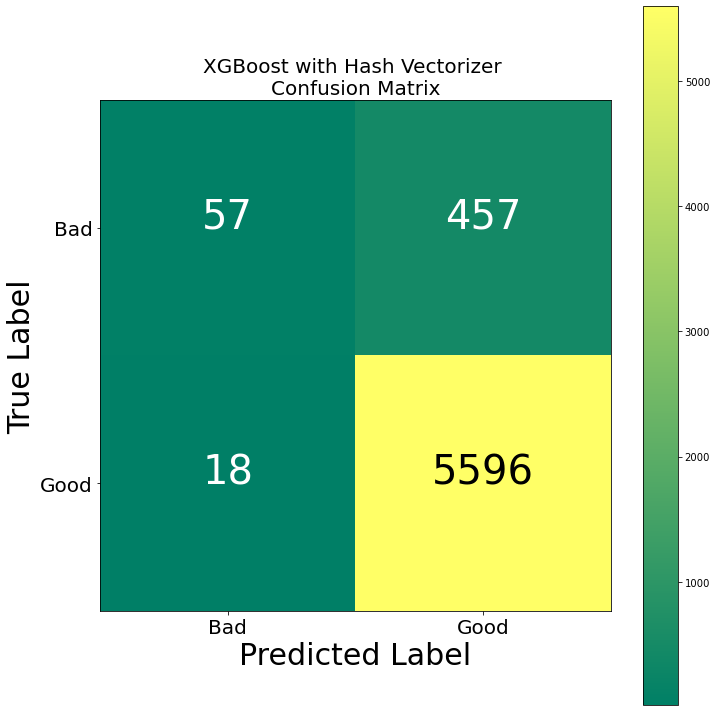

In [70]:
# Print confusion matrix for XGBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_xgb, "XGBoost", "Hash Vectorizer")

### 4.3.5 CatBoost with Hash Vectorizer

In [71]:
# Call the modeling function for Catboost with Hash Vectorizer and print f1 score
modeling(CatBoostClassifier(iterations=1500, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_catboost = y_pred

0:	learn: 0.3015521	total: 36.6ms	remaining: 54.9s
1:	learn: 0.2697295	total: 72.8ms	remaining: 54.5s
2:	learn: 0.2592152	total: 106ms	remaining: 52.9s
3:	learn: 0.2498172	total: 140ms	remaining: 52.3s
4:	learn: 0.2424537	total: 174ms	remaining: 51.9s
5:	learn: 0.2377506	total: 209ms	remaining: 52s
6:	learn: 0.2337696	total: 245ms	remaining: 52.3s
7:	learn: 0.2311321	total: 286ms	remaining: 53.4s
8:	learn: 0.2271743	total: 321ms	remaining: 53.2s
9:	learn: 0.2237477	total: 355ms	remaining: 52.9s
10:	learn: 0.2188604	total: 390ms	remaining: 52.7s
11:	learn: 0.2151557	total: 423ms	remaining: 52.5s
12:	learn: 0.2127553	total: 466ms	remaining: 53.3s
13:	learn: 0.2097863	total: 502ms	remaining: 53.2s
14:	learn: 0.2079046	total: 536ms	remaining: 53s
15:	learn: 0.2060889	total: 569ms	remaining: 52.8s
16:	learn: 0.2033626	total: 603ms	remaining: 52.6s
17:	learn: 0.2016338	total: 641ms	remaining: 52.8s
18:	learn: 0.2002012	total: 678ms	remaining: 52.9s
19:	learn: 0.1993492	total: 717ms	remaining

162:	learn: 0.1192192	total: 5.68s	remaining: 46.6s
163:	learn: 0.1190700	total: 5.72s	remaining: 46.6s
164:	learn: 0.1181933	total: 5.75s	remaining: 46.6s
165:	learn: 0.1176105	total: 5.79s	remaining: 46.5s
166:	learn: 0.1174519	total: 5.82s	remaining: 46.5s
167:	learn: 0.1173435	total: 5.86s	remaining: 46.4s
168:	learn: 0.1171248	total: 5.89s	remaining: 46.4s
169:	learn: 0.1169982	total: 5.93s	remaining: 46.4s
170:	learn: 0.1165468	total: 5.96s	remaining: 46.3s
171:	learn: 0.1160299	total: 6s	remaining: 46.3s
172:	learn: 0.1158774	total: 6.03s	remaining: 46.2s
173:	learn: 0.1155033	total: 6.06s	remaining: 46.2s
174:	learn: 0.1153244	total: 6.1s	remaining: 46.2s
175:	learn: 0.1151860	total: 6.13s	remaining: 46.1s
176:	learn: 0.1150444	total: 6.17s	remaining: 46.1s
177:	learn: 0.1148799	total: 6.2s	remaining: 46.1s
178:	learn: 0.1147447	total: 6.24s	remaining: 46s
179:	learn: 0.1143014	total: 6.27s	remaining: 46s
180:	learn: 0.1142090	total: 6.31s	remaining: 46s
181:	learn: 0.1141061	t

322:	learn: 0.0911999	total: 11.9s	remaining: 43.5s
323:	learn: 0.0911431	total: 12s	remaining: 43.5s
324:	learn: 0.0909231	total: 12s	remaining: 43.5s
325:	learn: 0.0908416	total: 12.1s	remaining: 43.5s
326:	learn: 0.0906287	total: 12.1s	remaining: 43.5s
327:	learn: 0.0904850	total: 12.2s	remaining: 43.5s
328:	learn: 0.0904317	total: 12.2s	remaining: 43.5s
329:	learn: 0.0903018	total: 12.3s	remaining: 43.5s
330:	learn: 0.0902288	total: 12.3s	remaining: 43.5s
331:	learn: 0.0901808	total: 12.4s	remaining: 43.5s
332:	learn: 0.0900373	total: 12.4s	remaining: 43.5s
333:	learn: 0.0899002	total: 12.5s	remaining: 43.5s
334:	learn: 0.0898311	total: 12.5s	remaining: 43.5s
335:	learn: 0.0895511	total: 12.5s	remaining: 43.5s
336:	learn: 0.0894853	total: 12.6s	remaining: 43.4s
337:	learn: 0.0894202	total: 12.6s	remaining: 43.5s
338:	learn: 0.0893571	total: 12.7s	remaining: 43.4s
339:	learn: 0.0893147	total: 12.7s	remaining: 43.4s
340:	learn: 0.0892613	total: 12.8s	remaining: 43.4s
341:	learn: 0.08

485:	learn: 0.0706887	total: 18.7s	remaining: 39s
486:	learn: 0.0706414	total: 18.7s	remaining: 38.9s
487:	learn: 0.0706096	total: 18.8s	remaining: 38.9s
488:	learn: 0.0705092	total: 18.8s	remaining: 38.9s
489:	learn: 0.0704886	total: 18.8s	remaining: 38.8s
490:	learn: 0.0703931	total: 18.9s	remaining: 38.8s
491:	learn: 0.0702866	total: 18.9s	remaining: 38.8s
492:	learn: 0.0699244	total: 19s	remaining: 38.7s
493:	learn: 0.0697919	total: 19s	remaining: 38.7s
494:	learn: 0.0696171	total: 19s	remaining: 38.7s
495:	learn: 0.0694422	total: 19.1s	remaining: 38.6s
496:	learn: 0.0692410	total: 19.1s	remaining: 38.6s
497:	learn: 0.0691296	total: 19.2s	remaining: 38.5s
498:	learn: 0.0690805	total: 19.2s	remaining: 38.5s
499:	learn: 0.0688825	total: 19.2s	remaining: 38.5s
500:	learn: 0.0686908	total: 19.3s	remaining: 38.4s
501:	learn: 0.0686907	total: 19.3s	remaining: 38.4s
502:	learn: 0.0686432	total: 19.4s	remaining: 38.4s
503:	learn: 0.0685744	total: 19.4s	remaining: 38.3s
504:	learn: 0.068532

648:	learn: 0.0570233	total: 25.2s	remaining: 33s
649:	learn: 0.0569844	total: 25.2s	remaining: 33s
650:	learn: 0.0568648	total: 25.3s	remaining: 33s
651:	learn: 0.0568285	total: 25.3s	remaining: 32.9s
652:	learn: 0.0567353	total: 25.4s	remaining: 32.9s
653:	learn: 0.0566349	total: 25.4s	remaining: 32.9s
654:	learn: 0.0565550	total: 25.4s	remaining: 32.8s
655:	learn: 0.0565111	total: 25.5s	remaining: 32.8s
656:	learn: 0.0564794	total: 25.5s	remaining: 32.7s
657:	learn: 0.0563044	total: 25.6s	remaining: 32.7s
658:	learn: 0.0562835	total: 25.6s	remaining: 32.7s
659:	learn: 0.0561609	total: 25.6s	remaining: 32.6s
660:	learn: 0.0561479	total: 25.7s	remaining: 32.6s
661:	learn: 0.0561174	total: 25.7s	remaining: 32.5s
662:	learn: 0.0560866	total: 25.8s	remaining: 32.5s
663:	learn: 0.0560520	total: 25.8s	remaining: 32.5s
664:	learn: 0.0559706	total: 25.8s	remaining: 32.4s
665:	learn: 0.0559387	total: 25.9s	remaining: 32.4s
666:	learn: 0.0558379	total: 25.9s	remaining: 32.4s
667:	learn: 0.0558

810:	learn: 0.0468066	total: 31.7s	remaining: 26.9s
811:	learn: 0.0467963	total: 31.7s	remaining: 26.9s
812:	learn: 0.0467478	total: 31.8s	remaining: 26.8s
813:	learn: 0.0467160	total: 31.8s	remaining: 26.8s
814:	learn: 0.0466986	total: 31.8s	remaining: 26.8s
815:	learn: 0.0465977	total: 31.9s	remaining: 26.7s
816:	learn: 0.0465852	total: 31.9s	remaining: 26.7s
817:	learn: 0.0465545	total: 31.9s	remaining: 26.6s
818:	learn: 0.0465041	total: 32s	remaining: 26.6s
819:	learn: 0.0464807	total: 32s	remaining: 26.6s
820:	learn: 0.0462453	total: 32.1s	remaining: 26.5s
821:	learn: 0.0461843	total: 32.1s	remaining: 26.5s
822:	learn: 0.0461532	total: 32.1s	remaining: 26.4s
823:	learn: 0.0461348	total: 32.2s	remaining: 26.4s
824:	learn: 0.0460151	total: 32.2s	remaining: 26.4s
825:	learn: 0.0460024	total: 32.3s	remaining: 26.3s
826:	learn: 0.0459726	total: 32.3s	remaining: 26.3s
827:	learn: 0.0459458	total: 32.3s	remaining: 26.2s
828:	learn: 0.0459426	total: 32.4s	remaining: 26.2s
829:	learn: 0.04

972:	learn: 0.0399279	total: 38.1s	remaining: 20.7s
973:	learn: 0.0398946	total: 38.2s	remaining: 20.6s
974:	learn: 0.0398199	total: 38.2s	remaining: 20.6s
975:	learn: 0.0398008	total: 38.3s	remaining: 20.5s
976:	learn: 0.0397852	total: 38.3s	remaining: 20.5s
977:	learn: 0.0396718	total: 38.3s	remaining: 20.5s
978:	learn: 0.0396516	total: 38.4s	remaining: 20.4s
979:	learn: 0.0396308	total: 38.4s	remaining: 20.4s
980:	learn: 0.0396201	total: 38.4s	remaining: 20.3s
981:	learn: 0.0395291	total: 38.5s	remaining: 20.3s
982:	learn: 0.0394757	total: 38.5s	remaining: 20.3s
983:	learn: 0.0394755	total: 38.6s	remaining: 20.2s
984:	learn: 0.0394616	total: 38.6s	remaining: 20.2s
985:	learn: 0.0394462	total: 38.6s	remaining: 20.1s
986:	learn: 0.0394398	total: 38.7s	remaining: 20.1s
987:	learn: 0.0394139	total: 38.7s	remaining: 20.1s
988:	learn: 0.0394000	total: 38.8s	remaining: 20s
989:	learn: 0.0393807	total: 38.8s	remaining: 20s
990:	learn: 0.0393797	total: 38.8s	remaining: 19.9s
991:	learn: 0.03

1131:	learn: 0.0344637	total: 44.3s	remaining: 14.4s
1132:	learn: 0.0344520	total: 44.3s	remaining: 14.3s
1133:	learn: 0.0344035	total: 44.3s	remaining: 14.3s
1134:	learn: 0.0343558	total: 44.4s	remaining: 14.3s
1135:	learn: 0.0343293	total: 44.4s	remaining: 14.2s
1136:	learn: 0.0343193	total: 44.5s	remaining: 14.2s
1137:	learn: 0.0343051	total: 44.5s	remaining: 14.2s
1138:	learn: 0.0343030	total: 44.6s	remaining: 14.1s
1139:	learn: 0.0342852	total: 44.6s	remaining: 14.1s
1140:	learn: 0.0342557	total: 44.6s	remaining: 14s
1141:	learn: 0.0342243	total: 44.7s	remaining: 14s
1142:	learn: 0.0341449	total: 44.7s	remaining: 14s
1143:	learn: 0.0340883	total: 44.7s	remaining: 13.9s
1144:	learn: 0.0340768	total: 44.8s	remaining: 13.9s
1145:	learn: 0.0340571	total: 44.8s	remaining: 13.8s
1146:	learn: 0.0340129	total: 44.9s	remaining: 13.8s
1147:	learn: 0.0339510	total: 44.9s	remaining: 13.8s
1148:	learn: 0.0339444	total: 44.9s	remaining: 13.7s
1149:	learn: 0.0339076	total: 45s	remaining: 13.7s
1

1292:	learn: 0.0310475	total: 50.3s	remaining: 8.06s
1293:	learn: 0.0310282	total: 50.4s	remaining: 8.02s
1294:	learn: 0.0310274	total: 50.4s	remaining: 7.98s
1295:	learn: 0.0310244	total: 50.4s	remaining: 7.94s
1296:	learn: 0.0310135	total: 50.5s	remaining: 7.9s
1297:	learn: 0.0310124	total: 50.5s	remaining: 7.86s
1298:	learn: 0.0309902	total: 50.5s	remaining: 7.82s
1299:	learn: 0.0309893	total: 50.6s	remaining: 7.78s
1300:	learn: 0.0309285	total: 50.6s	remaining: 7.74s
1301:	learn: 0.0309188	total: 50.7s	remaining: 7.7s
1302:	learn: 0.0309151	total: 50.7s	remaining: 7.66s
1303:	learn: 0.0308427	total: 50.7s	remaining: 7.63s
1304:	learn: 0.0308426	total: 50.8s	remaining: 7.59s
1305:	learn: 0.0308364	total: 50.8s	remaining: 7.55s
1306:	learn: 0.0307533	total: 50.8s	remaining: 7.51s
1307:	learn: 0.0307331	total: 50.9s	remaining: 7.47s
1308:	learn: 0.0306841	total: 50.9s	remaining: 7.43s
1309:	learn: 0.0306790	total: 51s	remaining: 7.39s
1310:	learn: 0.0306760	total: 51s	remaining: 7.35s

1448:	learn: 0.0282609	total: 56.2s	remaining: 1.98s
1449:	learn: 0.0282455	total: 56.2s	remaining: 1.94s
1450:	learn: 0.0282452	total: 56.2s	remaining: 1.9s
1451:	learn: 0.0282448	total: 56.3s	remaining: 1.86s
1452:	learn: 0.0282445	total: 56.3s	remaining: 1.82s
1453:	learn: 0.0281437	total: 56.4s	remaining: 1.78s
1454:	learn: 0.0281395	total: 56.4s	remaining: 1.74s
1455:	learn: 0.0281387	total: 56.4s	remaining: 1.71s
1456:	learn: 0.0281005	total: 56.5s	remaining: 1.67s
1457:	learn: 0.0280762	total: 56.5s	remaining: 1.63s
1458:	learn: 0.0280686	total: 56.5s	remaining: 1.59s
1459:	learn: 0.0280685	total: 56.6s	remaining: 1.55s
1460:	learn: 0.0280482	total: 56.6s	remaining: 1.51s
1461:	learn: 0.0280473	total: 56.7s	remaining: 1.47s
1462:	learn: 0.0280445	total: 56.7s	remaining: 1.43s
1463:	learn: 0.0280365	total: 56.7s	remaining: 1.4s
1464:	learn: 0.0280357	total: 56.8s	remaining: 1.36s
1465:	learn: 0.0280340	total: 56.8s	remaining: 1.32s
1466:	learn: 0.0280337	total: 56.9s	remaining: 1

**Classification Report**

In [72]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_catboost))

              precision    recall  f1-score   support

           0       0.62      0.39      0.48       514
           1       0.95      0.98      0.96      5614

    accuracy                           0.93      6128
   macro avg       0.78      0.69      0.72      6128
weighted avg       0.92      0.93      0.92      6128



**Confusion Matrix**

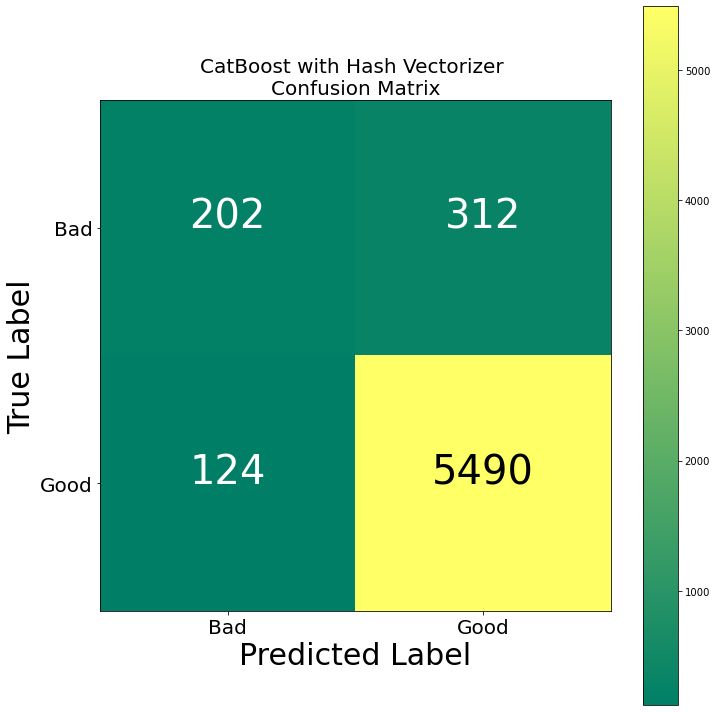

In [73]:
# Print confusion matrix for CatBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_catboost, "CatBoost", "Hash Vectorizer")

### 4.3.6 Comparison of Models with Hash Vectorizer

In [82]:
comparison_table(y_preds = [y_pred_hash_logreg, y_pred_hash_rf, y_pred_hash_nb, y_pred_hash_xgb, y_pred_hash_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

**Comparison Table**

In [83]:
# Print the comparision matrix
print('\nComparision Matrix of Models with Hash Vectorizer\n')
df_tv2


Comparision Matrix of Models with Hash Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.833551 bad       0.313146  0.824903  0.453961   
                                  good      0.981148  0.834343  0.901810   
                                  average   0.925118  0.833551  0.864245   
           Random Forest 0.917428 bad       1.000000  0.015564  0.030651   
                                  good      0.917320  1.000000  0.956877   
                                  average   0.924255  0.917428  0.879188   
           Naive Bayes   0.915633 bad       0.000000  0.000000  0.000000   
                                  good      0.916082  0.999466  0.955959   
                                  average   0.839243  0.915633  0.875776   
           XGBoost       0.922487 bad       0.760000  0.110895  0.193548   
                                  good      0.924500  0.996794  0.959287   
                                  average   0.910702  0.922487  0.895059   
           CatBoost      0.928851 bad       0.619632  0.392996  0.480952   
                                  good      0.946225  0.977912  0.961808   
                                  average   0.918832  0.928851  0.921475   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.833551 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Random Forest 0.917428 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           Naive Bayes   0.915633 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           XGBoost       0.922487 bad        514.0  
                                  good      5614.0  
                                  average   6128.0  
           CatBoost      0.928851 bad        514.0  
                                  good      5614.0  
                                  average   6128.0

**Average f1 score - Hash Vectorizer**

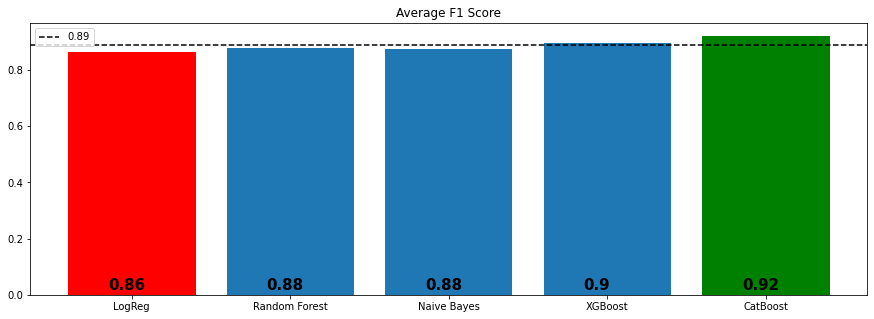

In [84]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")